In [1]:
!pip install -U tqdm transformers pydub -q

In [2]:
import warnings
import numpy as np
import pandas as pd
import os
from pathlib import Path
import subprocess

warnings.filterwarnings("ignore")

In [3]:
import torch
import torchaudio
from torch.nn.functional import pad
import torchaudio.functional as F
import torchaudio.transforms as T
from tqdm import tqdm
from transformers import Wav2Vec2Tokenizer, Wav2Vec2ForCTC, Wav2Vec2Processor
from pydub import AudioSegment
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained tokenizer and model
audio_processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
audio_model = Wav2Vec2ForCTC.from_pretrained('facebook/wav2vec2-large-960h').to(device)

text_model_id = "gpt2-large"
text_model = GPT2LMHeadModel.from_pretrained(text_model_id).to(device)
text_tokenizer = GPT2TokenizerFast.from_pretrained(text_model_id)


2025-03-03 19:32:14.300921: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-03 19:32:14.301007: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-03 19:32:14.302565: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-03 19:32:14.311456: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-03 19:32:15.687287: W tensorflow/compiler/tf2

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [4]:
base_folder = Path(r".").resolve()
csv_file = base_folder / 'sample.csv'
video_file = base_folder / 'sample.mp4'

In [5]:
audio_file = base_folder / 'sample.wav'
# subprocess.run(['ffmpeg', '-i', '-q' , video_file, audio_file, '-y']) 

# Read the CSV file with semicolon separator
df = pd.read_csv(csv_file, sep=';')

# Load the WAV audio
waveform, sample_rate = torchaudio.load(audio_file)
waveform = waveform.mean(dim=0)  # Ensure mono-channel

# Resample to 16KHz if needed
if sample_rate != 16000:
    transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
    waveform = transform(waveform)

def time_to_sample(time_str, sample_rate):
    h, m, s, ms = map(float, time_str.split(':'))
    total_seconds = h * 3600 + m * 60 + s + ms / 1000.0
    return int(total_seconds * sample_rate)

silence = torch.zeros(8000)  # 0.5s at 16KHz is 8000 samples, but reducing for memory

turns = []
current_speaker = None
current_audio = []
current_start = None
current_utterance = []

for index, row in df.iterrows():
    start_sample = time_to_sample(row['start'], 16000)
    stop_sample = time_to_sample(row['stop'], 16000)
    speaker = row['speaker']
    utterance = row['utterance']

    segment = waveform[start_sample:stop_sample]

    if speaker == current_speaker:
        current_audio.append(silence)
        current_audio.append(segment)
        current_utterance.append(utterance)
    else:
        if current_speaker is not None:
            turns.append({
                'speaker': current_speaker,
                'start': current_start,
                'audio': torch.cat(current_audio),
                'utterance': ' '.join(current_utterance)
            })
        current_speaker = speaker
        current_start = row['start']
        current_audio = [segment]
        current_utterance = [utterance]

if current_speaker is not None:
    turns.append({
        'speaker': current_speaker,
        'start': current_start,
        'audio': torch.cat(current_audio),
        'utterance': ' '.join(current_utterance)
    })

for turn in turns:
    print(f"Speaker: {turn['speaker']}, Start: {turn['start']}, Audio Samples: {turn['audio'].shape[0]}, Utterance: {turn['utterance']}")


Speaker: Ross, Start: 00:00:00:334, Audio Samples: 36704, Utterance: rachel, come on, talk to me
Speaker: Rachel , Start: 00:00:02:753, Audio Samples: 28688, Utterance: I cant even look at you right now
Speaker: Ross, Start: 00:00:12:100, Audio Samples: 7264, Utterance: rachel
Speaker: Rachel , Start: 00:00:13:00, Audio Samples: 3568, Utterance: Just get away from me
Speaker: Ross, Start: 00:00:13:722, Audio Samples: 42688, Utterance: It was a mistake, I made a mistake, ok? 
Speaker: Rachel , Start: 00:00:16:391, Audio Samples: 155472, Utterance: A mistake? What did you try to put it in? her purse?  Ross, you had sex with another woman.  You know what, I want you to leave. Get out of here, just get out.
Speaker: Ross, Start: 00:00:49:675, Audio Samples: 48704, Utterance: No, No, I wanna stay. I wanna takj about this.
Speaker: Rachel , Start: 00:00:52:800, Audio Samples: 47360, Utterance: ok, alright. How was she? 


In [6]:
def audio_perplexity(waveform):
    max_length = 4000  # at 16kHz
    stride = 400  # overlap
    
    # Tokenization
    input_values = audio_processor(waveform.numpy(), return_tensors="pt", sampling_rate=16000).input_values.to(device)
    seq_len = input_values.shape[1]
    
    nlls = []

    # tqdm bar
    inf_count = 0
    progress_bar = tqdm(range(0, seq_len, stride), desc="Processing", dynamic_ncols=True)
    for begin_loc in progress_bar:
        end_loc = min(begin_loc + max_length, seq_len)
        if end_loc - begin_loc < 1000:  # Avoid very short chunks
            print("Warning: Skipping too short sequence")
            continue

        input_chunk = input_values[:, begin_loc:end_loc]

        # Create valid target labels 
        target_ids = input_chunk.clone()
        target_ids[:, :-1] = -100  # Mask only some tokens

        with torch.no_grad():
            outputs = audio_model(input_chunk, labels=target_ids)
            neg_log_likelihood = outputs.loss

        if torch.isinf(neg_log_likelihood):
            inf_count += 1
            continue

        nlls.append(neg_log_likelihood.item())
        progress_bar.set_description(f"Chunk {begin_loc}-{end_loc} | inf: {inf_count} | NLL: {neg_log_likelihood.item():.4f}")

        if end_loc == seq_len:
            break

    return nlls

In [7]:
def text_perplexity(dialog, start_of_sentence=" "):
    
    #max_length = model.config.n_positions
    #max_length =  model.config.max_position_embeddings
    max_length = 500
    stride = 1
    
    pad_token_id = 0
    encodings = text_tokenizer(f"{start_of_sentence}".join(dialog), return_tensors="pt")
    seq_len = encodings.input_ids.size(1)
    padding_len = max_length -1 
    padded_input_ids = pad(torch.tensor([], dtype=torch.long), (0, padding_len), value=pad_token_id).unsqueeze(dim=0)
    encodings.input_ids = torch.cat([padded_input_ids, encodings.input_ids], dim=1)
    seq_len = encodings.input_ids.size(1)
    
    nlls = []
    prev_end_loc = padding_len
    for begin_loc in tqdm(range(0, seq_len, stride)):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc  # may be different from max_length on the last loop 
        begin_loc = max(padding_len, begin_loc)
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100
        with torch.no_grad():
            outputs = text_model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs.loss

        nlls.append(neg_log_likelihood.item())

        prev_end_loc = end_loc
        if end_loc == seq_len:
            break
        
    return nlls

In [8]:
for i, turn in enumerate(turns):
    print(f"Turn {i+1} out of {len(turns)}", flush=True)
    audio_nlls = audio_perplexity(turn['audio'])
    turns[i]["audio_perplexity"] = np.nanmean(np.asarray(audio_nlls))

for i, turn in enumerate(turns):
    print(f"Turn {i+1} out of {len(turns)}", flush=True)
    text_nlls = text_perplexity(turn['utterance'])
    turns[i]["text_perplexity"] = np.nanmean(np.asarray(text_nlls))    

Turn 1 out of 8


Chunk 32800-36704 | inf: 0 | NLL: -3.7749:  89%|████████▉ | 82/92 [00:04<00:00, 18.39it/s]

Turn 2 out of 8



Chunk 24800-28688 | inf: 0 | NLL: 2.7888:  86%|████████▌ | 62/72 [00:01<00:00, 42.91it/s] 

Turn 3 out of 8



Chunk 3600-7264 | inf: 0 | NLL: 2.3619:  47%|████▋     | 9/19 [00:00<00:00, 39.80it/s] 

Turn 4 out of 8



Chunk 0-3568 | inf: 0 | NLL: 2.9136:   0%|          | 0/9 [00:00<?, ?it/s]

Turn 5 out of 8



Chunk 38800-42688 | inf: 0 | NLL: 14.4817:  91%|█████████ | 97/107 [00:02<00:00, 43.25it/s]

Turn 6 out of 8



Chunk 151600-155472 | inf: 0 | NLL: 4.0026:  97%|█████████▋| 379/389 [00:08<00:00, 42.45it/s] 

Turn 7 out of 8



Chunk 44800-48704 | inf: 0 | NLL: 1.9135:  92%|█████████▏| 112/122 [00:02<00:00, 40.81it/s] 

Turn 8 out of 8



Chunk 43600-47360 | inf: 0 | NLL: 20.8280:  92%|█████████▏| 109/119 [00:02<00:00, 42.46it/s]

Turn 1 out of 8



  6%|▌         | 31/531 [00:01<00:19, 25.60it/s]

Turn 2 out of 8



  7%|▋         | 39/539 [00:01<00:18, 27.63it/s]

Turn 3 out of 8



  1%|          | 5/505 [00:00<00:19, 25.87it/s]

Turn 4 out of 8



  5%|▍         | 24/524 [00:00<00:17, 28.06it/s]

Turn 5 out of 8



  9%|▉         | 48/548 [00:01<00:19, 25.65it/s]

Turn 6 out of 8



 28%|██▊       | 193/693 [00:13<00:35, 14.11it/s]

Turn 7 out of 8



 10%|▉         | 54/554 [00:01<00:18, 27.28it/s]

Turn 8 out of 8



  6%|▌         | 30/530 [00:01<00:16, 29.95it/s]


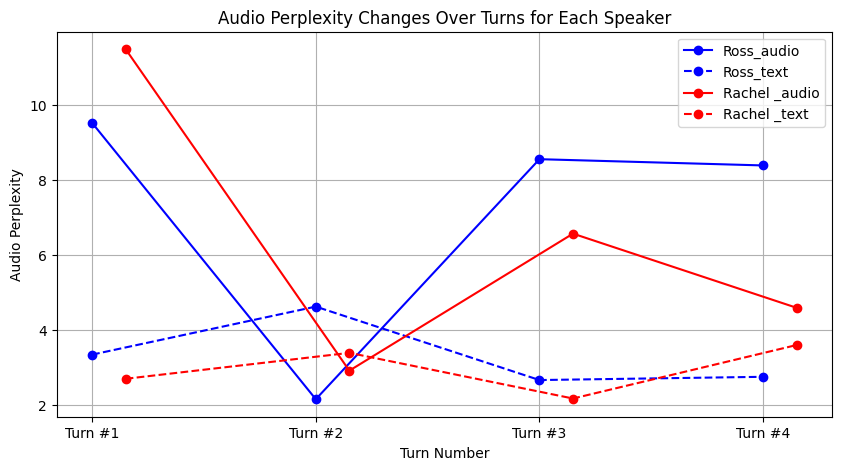

In [9]:
import matplotlib.pyplot as plt

# Separate data by speaker
speakers = [turn['speaker'] for turn in turns[:2]]

# Prepare data for plotting
speaker_audio_perplexity = {speaker: [] for speaker in speakers}
speaker_text_perplexity = {speaker: [] for speaker in speakers}
for turn in turns:
    speaker_audio_perplexity[turn['speaker']].append(turn['audio_perplexity'])
    speaker_text_perplexity[turn['speaker']].append(turn['text_perplexity'])

colors = { speakers[0]: "blue", speakers[1]: "red" }

# Generate x values with offset for second speaker
x_ticks = [f"Turn #{i+1}" for i in range(len(speaker_audio_perplexity[speakers[0]]))]
x_values = {speakers[0]: list(range(len(speaker_audio_perplexity[speakers[0]]))),
            speakers[1]: [x + 0.15 for x in range(len(speaker_audio_perplexity[speakers[1]]))]}

plt.figure(figsize=(10, 5))
for speaker in speakers:
    plt.plot(x_values[speaker], speaker_audio_perplexity[speaker], marker='o', label=speaker + "_audio", color = colors[speaker])
    plt.plot(x_values[speaker], speaker_text_perplexity[speaker], marker='o', label=speaker + "_text", color = colors[speaker], linestyle = '--')

    
plt.xticks(range(len(x_ticks)), x_ticks)
plt.xlabel('Turn Number')
plt.ylabel('Audio Perplexity')
plt.title('Audio Perplexity Changes Over Turns for Each Speaker')
plt.legend()
plt.grid(True)
plt.show()
